In [1]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [125]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch == 25 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
          flag = 1
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values


In [ ]:
model = allcnn_t().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/50], Step [1000/3125], Loss: 1.6618
Epoch [1/50], Step [2000/3125], Loss: 1.8104
Epoch [1/50], Step [3000/3125], Loss: 1.0856
Accuracy of the network on the test images: 53.01 %
Epoch [2/50], Step [1000/3125], Loss: 1.0043
Epoch [2/50], Step [2000/3125], Loss: 1.0001
Epoch [2/50], Step [3000/3125], Loss: 0.6464
Accuracy of the network on the test images: 71.14 %
Epoch [3/50], Step [1000/3125], Loss: 0.6538
Epoch [3/50], Step [2000/3125], Loss: 0.3558
Epoch [3/50], Step [3000/3125], Loss: 0.3802
Accuracy of the network on the test images: 78.98 %
Epoch [4/50], Step [1000/3125], Loss: 0.5748
Epoch [4/50], Step [2000/3125], Loss: 0.2281
Epoch [4/50], Step [3000/3125], Loss: 0.7438
Accuracy of the network on the test images: 79.24 %
Epoch [5/50], Step [1000/3125], Loss: 0.3864
Epoch [5/50], Step [2000/3125], Loss: 0.3971
Epoch [5/50], Step [3000/3125], Loss: 0.1077
Accuracy of the network on the test images: 80.28 %
Epoch [6/50], Step [1000/3125], Loss: 0.

In [ ]:
torch.save(model, './Intital_hw2_p3_model/model1.pt')

### Increasing the number of epochs

In [ ]:
# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch == 40 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
          flag = 1
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values

In [ ]:
model = allcnn_t().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 1.9664
Epoch [1/100], Step [2000/3125], Loss: 1.1284
Epoch [1/100], Step [3000/3125], Loss: 1.0749
Accuracy of the network on the test images: 53.77 %
Epoch [2/100], Step [1000/3125], Loss: 1.2159
Epoch [2/100], Step [2000/3125], Loss: 0.6642
Epoch [2/100], Step [3000/3125], Loss: 0.8375
Accuracy of the network on the test images: 71.08 %
Epoch [3/100], Step [1000/3125], Loss: 1.0900
Epoch [3/100], Step [2000/3125], Loss: 0.5668
Epoch [3/100], Step [3000/3125], Loss: 0.6083
Accuracy of the network on the test images: 72.67 %
Epoch [4/100], Step [1000/3125], Loss: 0.5771
Epoch [4/100], Step [2000/3125], Loss: 0.3854
Epoch [4/100], Step [3000/3125], Loss: 0.6999
Accuracy of the network on the test images: 78.71 %
Epoch [5/100], Step [1000/3125], Loss: 0.5968
Epoch [5/100], Step [2000/3125], Loss: 0.7876
Epoch [5/100], Step [3000/3125], Loss: 0.3321
Accuracy of the network on the test images: 81.44 %
Epoch [6/100], Step [1000

In [ ]:
torch.save(model, './Intital_hw2_p3_model/model1_100epoch_40lr.pt')

In [ ]:
plt.plot(train_error)

### Part 3.a.

### Changing the learning rate and weight decay in train code

In [26]:
# The training loop - changing the learning rate and weight decay as per suggestion given in the document

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    schedule_lr = 0.1
    for epoch in range(epochs):
        correct = 0
        total = 0
        # flag = 0
        running_loss = 0.0
        # if epoch == 25 and flag == 0:
        #   for op_params in optimizer.param_groups:
        #     op_params['lr'] = 0.001
        #   flag = 1
        if epoch % 40 == 0 and epoch!=0:
           schedule_lr = schedule_lr * 0.1
           for op_params in optimizer.param_groups:
                op_params['lr'] = schedule_lr
        # print(schedule_lr)
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              # for tag, value in info.items():
              #   logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        running_loss = 0.0

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values

In [28]:
model = allcnn_t().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 1.9352
Epoch [1/100], Step [2000/3125], Loss: 1.5120
Epoch [1/100], Step [3000/3125], Loss: 1.1957
Accuracy of the network on the test images: 51.93 %
Epoch [2/100], Step [1000/3125], Loss: 1.2702
Epoch [2/100], Step [2000/3125], Loss: 1.0516
Epoch [2/100], Step [3000/3125], Loss: 1.2834
Accuracy of the network on the test images: 64.97 %
Epoch [3/100], Step [1000/3125], Loss: 1.1534
Epoch [3/100], Step [2000/3125], Loss: 1.0696
Epoch [3/100], Step [3000/3125], Loss: 0.5838
Accuracy of the network on the test images: 73.52 %
Epoch [4/100], Step [1000/3125], Loss: 0.6224
Epoch [4/100], Step [2000/3125], Loss: 0.7867
Epoch [4/100], Step [3000/3125], Loss: 1.0041
Accuracy of the network on the test images: 76.08 %
Epoch [5/100], Step [1000/3125], Loss: 0.7433
Epoch [5/100], Step [2000/3125], Loss: 1.4335
Epoch [5/100], Step [3000/3125], Loss: 0.5215
Accuracy of the network on the test images: 75.83 %
Epoch [6/100], Step [1000

In [29]:
#torch.save(model, './Intital_hw2_p3_model/model3_100epoch_40lr_1e4wt.pt')
torch.save(model, 'model4_100epoch_40lr_1e4wt.pt')

In [30]:
## saving these for plotting val_error,val_loss_values,train_error,train_loss_values
import numpy as np
np.save('val_error4.npy', np.array(val_error))
np.save('val_loss_values4.npy', np.array(val_loss_values))
np.save('train_error4.npy', np.array(train_error))
np.save('train_loss_values4.npy', np.array(train_loss_values))

In [31]:
np.array(train_error).min(), np.array(train_error).max()

(0.0, 59.788)

In [32]:
np.array(val_error).min(), np.array(val_error).max()

(10.799999999999997, 48.07)

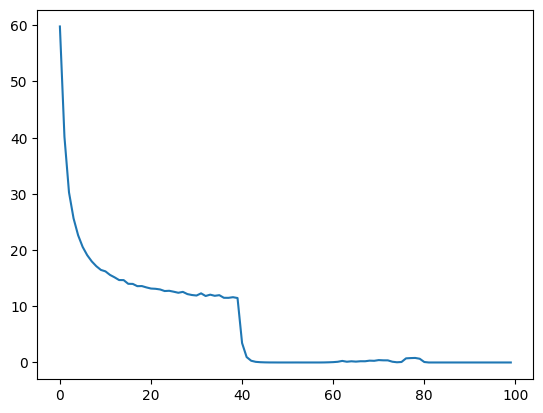

In [33]:
plt.plot(train_error)

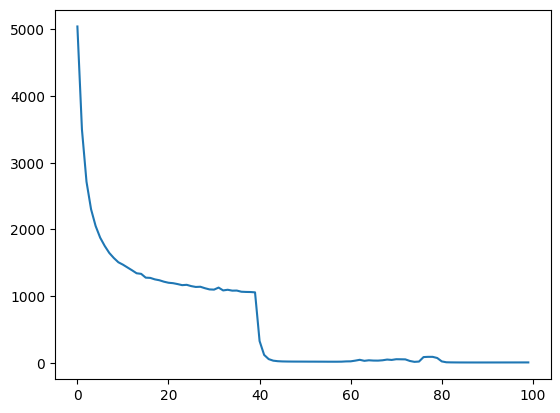

In [34]:
plt.plot(train_loss_values)

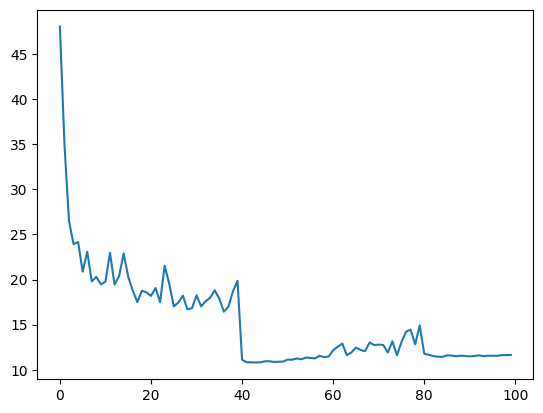

In [35]:
plt.plot(val_error)

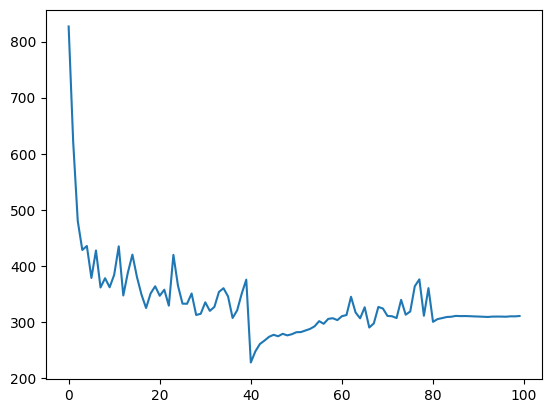

In [36]:
plt.plot(val_loss_values)

In [ ]:
final_model = torch.load('model4_100epoch_40lr_1e4wt.pt') ## checking if the model got stored
for parameter in final_model.parameters():
    print(parameter)

In [38]:
np.array(np.load('val_error4.npy')).min(), np.array(np.load('val_error4.npy')).max() ## checking if losses and error got stored

(10.799999999999997, 48.07)

### Part 3.b.

In [76]:
valloader_perturb = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True)

In [78]:
images, labels = next(iter(valloader_perturb))
print(len(labels))

100


In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)

In [80]:
# Move tensors to configured device
images = images.to(device)
labels = labels.to(device)
#Forward Pass
images.requires_grad_()
outputs = final_model(images)
loss = criterion(outputs, labels)
optimizer.zero_grad()
loss.backward()
dx = images.grad.data.clone()

In [81]:
_, predicted = torch.max(outputs.data, 1)

In [82]:
pred_np = predicted.cpu().numpy()
labels_np = labels.cpu().numpy()
correct_list =  np.argwhere(pred_np==labels_np)
incorrect_list = np.argwhere(pred_np!=labels_np)
len(correct_list), len(incorrect_list)

(87, 13)

In [61]:
grad_images = dx.cpu().detach().numpy()
grad_images.shape

(100, 3, 32, 32)

In [87]:
grad_images[0]

array([[[-2.2954197e-07, -3.6932423e-07, -5.3539776e-07, ...,
         -2.4761562e-06, -2.1135188e-06,  1.0691587e-06],
        [-3.0954146e-07,  5.5469638e-07,  3.4660695e-07, ...,
          8.0297281e-07,  3.4435952e-06, -3.0790754e-06],
        [-3.6810181e-07,  5.2060255e-07, -1.3039865e-07, ...,
         -1.5888264e-07,  1.2268226e-06, -4.3964569e-06],
        ...,
        [-9.4273213e-07,  1.3156865e-06, -8.5363638e-07, ...,
         -3.5474909e-07,  2.7809955e-07,  5.4960253e-08],
        [ 4.5706034e-07,  8.7817671e-07, -1.8635291e-07, ...,
         -3.1044780e-07,  1.5510227e-07, -1.1233990e-08],
        [-6.2467080e-07, -2.3304196e-08,  1.0674343e-06, ...,
          7.2952723e-08,  5.2107740e-08, -1.7199664e-09]],

       [[-2.1403960e-07, -2.5057659e-07, -3.0784571e-07, ...,
         -1.5302224e-06, -1.8854701e-06,  6.6390862e-07],
        [-2.5065205e-07,  8.5156319e-07,  1.0004476e-06, ...,
          2.4340586e-06,  4.6497303e-06, -3.1669676e-06],
        [-6.1819247e-07, 

In [108]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [101]:
np.squeeze(scaler.fit_transform(grad_images_transformed[0].T.flatten().reshape((-1,1)))).reshape((32,32,3)).max()

1.0

In [109]:
grad_images_transformed[0].max()

0.4530796

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


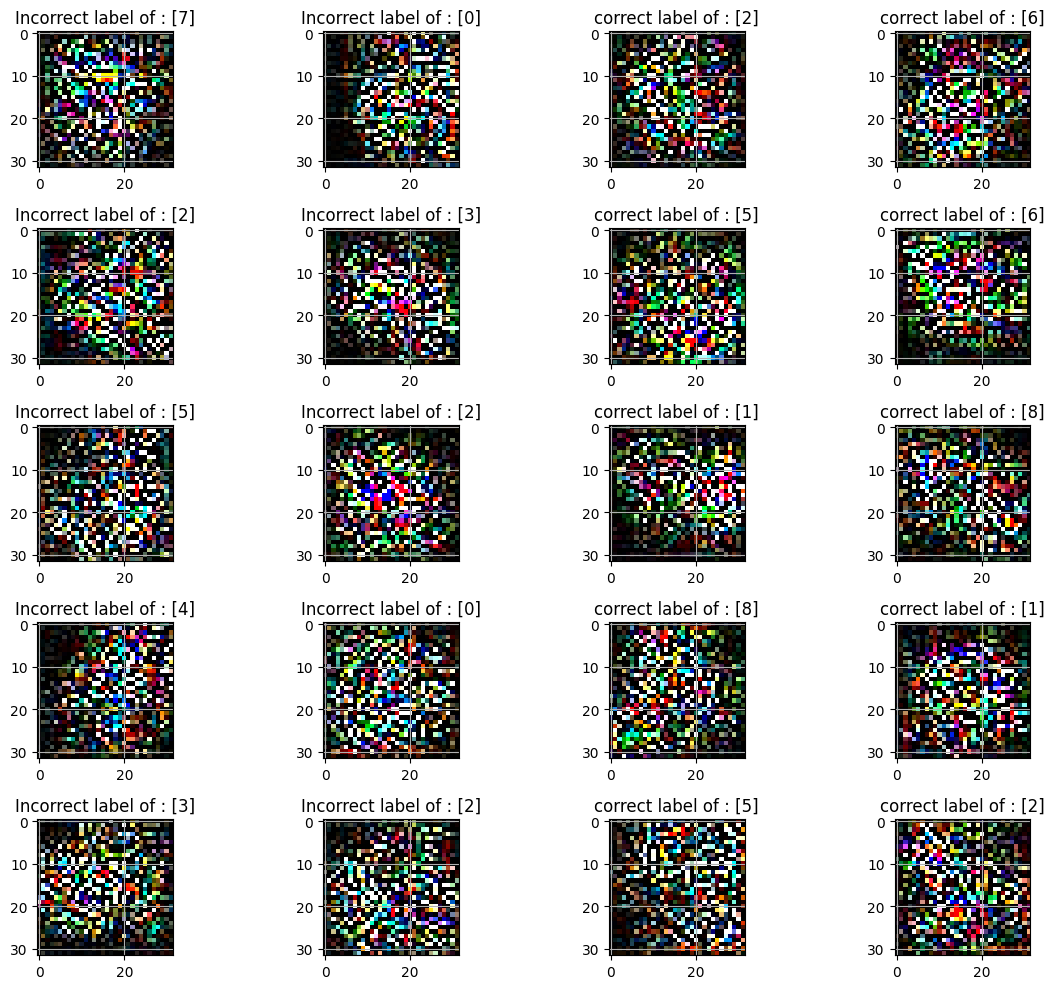

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Create some data for plotting
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Create a 5x4 grid of subplots
fig, axes = plt.subplots(5, 4, figsize=(12, 10))

# Loop to populate each subplot with data
for i in range(5):
    for j in range(2):
        ax = axes[i, j]
        print(np.squeeze(grad_images_transformed[incorrect_list[(i*2)+j]]).T.shape)
        ax.imshow((np.squeeze(scaler.fit_transform(grad_images[incorrect_list[(i*2)+j]].T.flatten().reshape((-1,1)))).reshape((32,32,3))*255).astype(int))
        ax.set_title(f'Incorrect label of : {labels_np[incorrect_list[(i*2)+j]]}')
        ax.grid(True)

# Loop to populate each subplot with data
for i in range(5):
    for j in range(2, 4):
        ax = axes[i, j]
        ax.imshow((np.squeeze(scaler.fit_transform(grad_images[correct_list[(i*2)+j]].T.flatten().reshape((-1,1)))).reshape((32,32,3))*255).astype(int))
        ax.set_title(f'correct label of : {labels_np[correct_list[(i*2)+j]]}')
        ax.grid(True)


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [121]:
## 5 step perturbation
eps = 8
loss_list_perturb = []
images, labels = next(iter(valloader_perturb))
print(len(labels))
# Move tensors to configured device
images = images.to(device)
labels = labels.to(device)


for i in range(5):
  #Forward Pass
  images.requires_grad_()
  outputs = final_model(images)
  loss = criterion(outputs, labels)
  optimizer.zero_grad()
  loss.backward()
  dx = images.grad.data.clone()
  loss_list_perturb.append(loss.item())
  with torch.no_grad():
    images += eps*torch.sign(dx)


100


In [122]:
np.array(loss_list_perturb)

array([2.28495598e-01, 3.58503265e+01, 2.56252625e+02, 7.91883362e+02,
       1.57389417e+03])

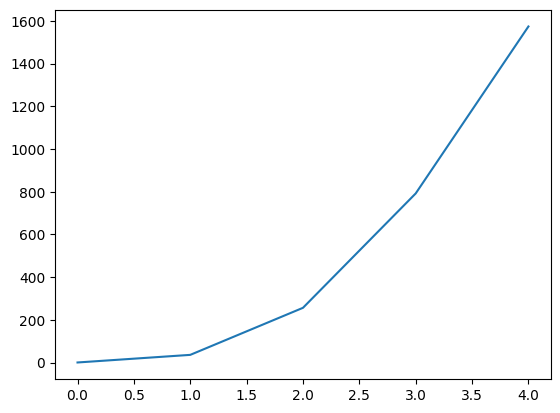

In [123]:
plt.plot(np.array(loss_list_perturb))

## Part 3.c.

In [128]:
## original validation images

correct = 0
total = 0
final_model.eval()
for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = final_model(images)
    loss = criterion(outputs, labels)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))


Accuracy of the network on the test images: 88.36 %


In [129]:
## 1 step perturbation to validation images

correct = 0
total = 0
for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad_()
    outputs = final_model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    dx = images.grad.data.clone()

    ## 1 step perturbation
    with torch.no_grad():
      images += eps*torch.sign(dx)

    outputs = final_model(images)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))


Accuracy of the network on the test images: 9.21 %
